<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Group Number: 21   |                  |                |
| ----------- | ----------------------- | -------------- |
| Student 1   | N.P.G.T. van Beuningen  | 1353624        |
| Student 2   | D.P.M. van der Hoorn    | 1873334        |
| Student 3   | L.R. Siecker            | 1344838        |

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [ ]:
# Change the following  line to the directory this notebook is (if using colab)
# In case you do not know the path, open the file navigator on the left in colab
# Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
# UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [ ]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [ ]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


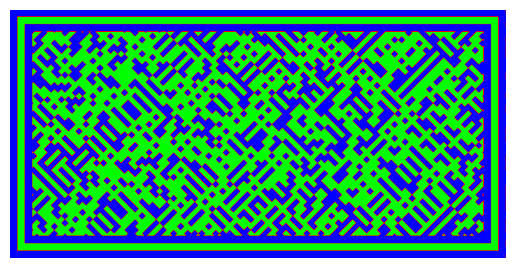

In [ ]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [ ]:
###     YOUR CODE FOR TASK 1    ###
class OriginPredictor(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            sc.SymmetryPool(),

            nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(24, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [ ]:
from torch.utils.data import DataLoader

# dataloader training
dataloader_training = DataLoader(dataset=train_dataset,
                                 batch_size=32,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=val_dataset,
                                   batch_size=32,
                                   shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class PlotTraining():
    def __init__(self):
      self.train_accuracy = []
      self.train_loss = []
      self.evaluation_accuracy = []
      self.evaluation_loss = []
      self.test_accuracy = []
      self.test_loss = []

    def add_train(self, accuracy, loss):
      self.train_accuracy.append(accuracy)
      self.train_loss.append(loss)

    def add_evaluation(self, accuracy, loss):
      self.evaluation_accuracy.append(accuracy)
      self.evaluation_loss.append(loss)

    def add_test(self, accuracy, loss):
      self.test_accuracy.append(accuracy)
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax1.set_ylabel('accuracy')
      ax2 = ax1.twinx()
      ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_accuracy:
        ax1.plot(list(range(len(self.train_accuracy))), self.train_accuracy, label = "Training Accuracy", color=color[0])
      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_accuracy:
        ax1.plot(list(range(len(self.evaluation_accuracy))), self.evaluation_accuracy, label = "Validation Accuracy", color=color[2])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_accuracy:
        ax1.plot(list(range(len(self.test_accuracy))), self.test_accuracy, label = "Test Accuracy", color=color[4])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()
      

In [ ]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):
        plotter = PlotTraining()

        for epoch in tqdm(range(self.epochs)):
                 
            train_acc, val_acc = [], []

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
                max_index_pred = torch.argmax(out_softmax, dim=1)
                max_index_test = torch.argmax(target, dim=1)

                pred_correct = torch.sum(max_index_pred == max_index_test)

                accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                train_acc.append(accuracy_value)
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
                    max_index_pred = torch.argmax(out_softmax, dim=1)
                    max_index_test = torch.argmax(target, dim=1)

                    pred_correct = torch.sum(max_index_pred == max_index_test)

                    accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                    val_acc.append(accuracy_value)

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

                  
                
            # print the results
            print(
                f' EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'TRAIN-ACC: {np.mean(train_acc):.2f}',end=' ')
            print(f'TRAIN-LOSS: {np.mean(train_losses):.4f}',end=' | ')
            print(f'VAL-ACC: {np.mean(val_acc):.2f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
            plotter.add_train(np.mean(train_acc), np.mean(train_losses))
            plotter.add_evaluation(np.mean(val_acc), np.mean(valid_losses))
        plotter.plot()
   

  5%|▌         | 1/20 [00:01<00:36,  1.94s/it]

 EPOCH: 01/20 TRAIN-ACC: 37.43 TRAIN-LOSS: 1.0881 | VAL-ACC: 43.60 VAL-LOSS: 1.0623


 10%|█         | 2/20 [00:03<00:32,  1.79s/it]

 EPOCH: 02/20 TRAIN-ACC: 59.34 TRAIN-LOSS: 0.9521 | VAL-ACC: 64.88 VAL-LOSS: 0.9129


 15%|█▌        | 3/20 [00:05<00:29,  1.75s/it]

 EPOCH: 03/20 TRAIN-ACC: 79.67 TRAIN-LOSS: 0.7849 | VAL-ACC: 83.18 VAL-LOSS: 0.7747


 20%|██        | 4/20 [00:07<00:27,  1.74s/it]

 EPOCH: 04/20 TRAIN-ACC: 89.35 TRAIN-LOSS: 0.6920 | VAL-ACC: 90.48 VAL-LOSS: 0.6890


 25%|██▌       | 5/20 [00:08<00:26,  1.79s/it]

 EPOCH: 05/20 TRAIN-ACC: 93.67 TRAIN-LOSS: 0.6446 | VAL-ACC: 83.38 VAL-LOSS: 0.7178


 30%|███       | 6/20 [00:10<00:24,  1.78s/it]

 EPOCH: 06/20 TRAIN-ACC: 95.29 TRAIN-LOSS: 0.6199 | VAL-ACC: 94.84 VAL-LOSS: 0.6350


 35%|███▌      | 7/20 [00:12<00:22,  1.74s/it]

 EPOCH: 07/20 TRAIN-ACC: 96.14 TRAIN-LOSS: 0.6106 | VAL-ACC: 93.65 VAL-LOSS: 0.6320


 40%|████      | 8/20 [00:14<00:20,  1.72s/it]

 EPOCH: 08/20 TRAIN-ACC: 96.65 TRAIN-LOSS: 0.6020 | VAL-ACC: 94.59 VAL-LOSS: 0.6301


 45%|████▌     | 9/20 [00:15<00:18,  1.71s/it]

 EPOCH: 09/20 TRAIN-ACC: 96.90 TRAIN-LOSS: 0.5975 | VAL-ACC: 94.00 VAL-LOSS: 0.6245


 50%|█████     | 10/20 [00:17<00:16,  1.70s/it]

 EPOCH: 10/20 TRAIN-ACC: 97.07 TRAIN-LOSS: 0.5924 | VAL-ACC: 95.59 VAL-LOSS: 0.6098


 55%|█████▌    | 11/20 [00:19<00:15,  1.69s/it]

 EPOCH: 11/20 TRAIN-ACC: 97.51 TRAIN-LOSS: 0.5893 | VAL-ACC: 96.28 VAL-LOSS: 0.6034


 60%|██████    | 12/20 [00:20<00:13,  1.72s/it]

 EPOCH: 12/20 TRAIN-ACC: 97.34 TRAIN-LOSS: 0.5865 | VAL-ACC: 95.93 VAL-LOSS: 0.6011


 65%|██████▌   | 13/20 [00:22<00:12,  1.77s/it]

 EPOCH: 13/20 TRAIN-ACC: 97.73 TRAIN-LOSS: 0.5847 | VAL-ACC: 94.35 VAL-LOSS: 0.6146


 70%|███████   | 14/20 [00:24<00:10,  1.77s/it]

 EPOCH: 14/20 TRAIN-ACC: 97.99 TRAIN-LOSS: 0.5815 | VAL-ACC: 97.12 VAL-LOSS: 0.5970


 75%|███████▌  | 15/20 [00:26<00:08,  1.74s/it]

 EPOCH: 15/20 TRAIN-ACC: 98.42 TRAIN-LOSS: 0.5765 | VAL-ACC: 98.07 VAL-LOSS: 0.5862


 80%|████████  | 16/20 [00:27<00:06,  1.72s/it]

 EPOCH: 16/20 TRAIN-ACC: 97.93 TRAIN-LOSS: 0.5807 | VAL-ACC: 97.27 VAL-LOSS: 0.5900


 85%|████████▌ | 17/20 [00:29<00:05,  1.71s/it]

 EPOCH: 17/20 TRAIN-ACC: 98.29 TRAIN-LOSS: 0.5767 | VAL-ACC: 97.42 VAL-LOSS: 0.5864


 90%|█████████ | 18/20 [00:31<00:03,  1.70s/it]

 EPOCH: 18/20 TRAIN-ACC: 98.26 TRAIN-LOSS: 0.5766 | VAL-ACC: 96.18 VAL-LOSS: 0.5996


 95%|█████████▌| 19/20 [00:32<00:01,  1.69s/it]

 EPOCH: 19/20 TRAIN-ACC: 97.74 TRAIN-LOSS: 0.5807 | VAL-ACC: 96.33 VAL-LOSS: 0.5941


100%|██████████| 20/20 [00:34<00:00,  1.74s/it]

 EPOCH: 20/20 TRAIN-ACC: 98.74 TRAIN-LOSS: 0.5721 | VAL-ACC: 96.03 VAL-LOSS: 0.5978


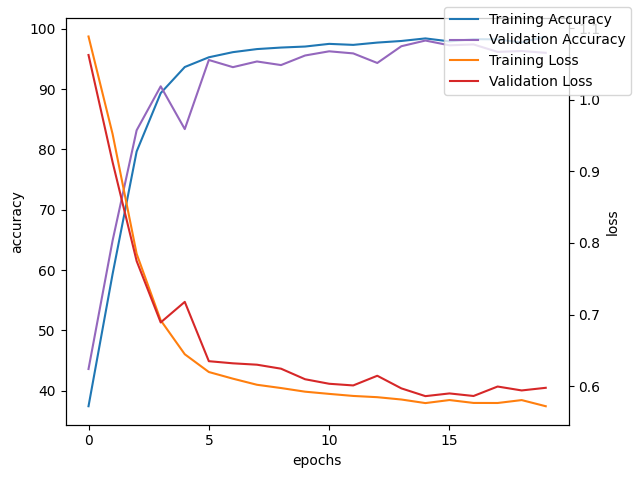

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

originpred = OriginPredictor()

model = originpred.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  epochs=20)

trainer.run_trainer()

Carpet from Convolushahr is predicted as Convolushahr


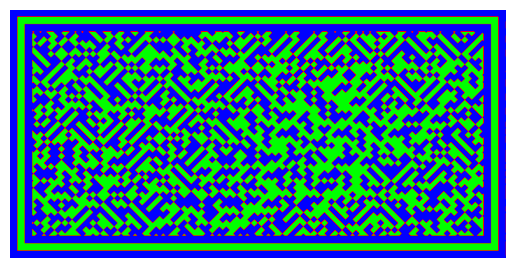

In [ ]:
'''
(For the test dataset)
1. For each class a good classified carpet
2. For each class if possible a wrongly classified carpet
3. Accuracy of the model
'''

idx = np.random.randint(0,X_test.size(0))

model.eval()

with torch.no_grad():
    out = model(X_test[idx,None].to(device))  # send through model/network


out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index = torch.argmax(out_softmax, dim=1)

test_label = oh_to_label(y_test[idx,None])[0]

cls_dict = {0: 'Convolushahr', 1:'Transformabad', 2:'Reinforciya'}
pred_label = cls_dict[max_index.cpu().numpy()[0]]
show_carpet(X_test, idx)
print('Carpet from', test_label, 'is predicted as', pred_label)

In [ ]:
model.eval()
with torch.no_grad():
    out = model(X_val.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model(X_test.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

Accuracy of the model on the validation set: 96.1%
Accuracy of the model on the test set: 97.4%


## Task 1: Question 5d

  5%|▌         | 1/20 [00:00<00:15,  1.25it/s]

 EPOCH: 01/20 TRAIN-ACC: 40.81 TRAIN-LOSS: 1.0750 | VAL-ACC: 67.96 VAL-LOSS: 0.9143


 10%|█         | 2/20 [00:01<00:14,  1.27it/s]

 EPOCH: 02/20 TRAIN-ACC: 94.63 TRAIN-LOSS: 0.6652 | VAL-ACC: 98.07 VAL-LOSS: 0.5910


 15%|█▌        | 3/20 [00:02<00:13,  1.28it/s]

 EPOCH: 03/20 TRAIN-ACC: 99.26 TRAIN-LOSS: 0.5767 | VAL-ACC: 99.36 VAL-LOSS: 0.5691


 20%|██        | 4/20 [00:03<00:12,  1.28it/s]

 EPOCH: 04/20 TRAIN-ACC: 99.61 TRAIN-LOSS: 0.5644 | VAL-ACC: 99.21 VAL-LOSS: 0.5694


 25%|██▌       | 5/20 [00:04<00:12,  1.21it/s]

 EPOCH: 05/20 TRAIN-ACC: 99.76 TRAIN-LOSS: 0.5614 | VAL-ACC: 99.11 VAL-LOSS: 0.5691


 30%|███       | 6/20 [00:05<00:12,  1.12it/s]

 EPOCH: 06/20 TRAIN-ACC: 99.95 TRAIN-LOSS: 0.5563 | VAL-ACC: 99.26 VAL-LOSS: 0.5634


 35%|███▌      | 7/20 [00:06<00:12,  1.08it/s]

 EPOCH: 07/20 TRAIN-ACC: 99.88 TRAIN-LOSS: 0.5572 | VAL-ACC: 99.11 VAL-LOSS: 0.5669


 40%|████      | 8/20 [00:07<00:11,  1.06it/s]

 EPOCH: 08/20 TRAIN-ACC: 99.91 TRAIN-LOSS: 0.5556 | VAL-ACC: 99.40 VAL-LOSS: 0.5622


 45%|████▌     | 9/20 [00:07<00:09,  1.13it/s]

 EPOCH: 09/20 TRAIN-ACC: 99.95 TRAIN-LOSS: 0.5543 | VAL-ACC: 99.60 VAL-LOSS: 0.5581


 50%|█████     | 10/20 [00:08<00:08,  1.18it/s]

 EPOCH: 10/20 TRAIN-ACC: 99.97 TRAIN-LOSS: 0.5527 | VAL-ACC: 99.80 VAL-LOSS: 0.5568


 55%|█████▌    | 11/20 [00:09<00:07,  1.21it/s]

 EPOCH: 11/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5520 | VAL-ACC: 99.70 VAL-LOSS: 0.5579


 60%|██████    | 12/20 [00:10<00:06,  1.23it/s]

 EPOCH: 12/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5518 | VAL-ACC: 99.85 VAL-LOSS: 0.5565


 65%|██████▌   | 13/20 [00:10<00:05,  1.25it/s]

 EPOCH: 13/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5516 | VAL-ACC: 99.75 VAL-LOSS: 0.5560


 70%|███████   | 14/20 [00:11<00:04,  1.27it/s]

 EPOCH: 14/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.85 VAL-LOSS: 0.5559


 75%|███████▌  | 15/20 [00:12<00:03,  1.29it/s]

 EPOCH: 15/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.75 VAL-LOSS: 0.5559


 80%|████████  | 16/20 [00:13<00:03,  1.29it/s]

 EPOCH: 16/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.75 VAL-LOSS: 0.5555


 85%|████████▌ | 17/20 [00:13<00:02,  1.28it/s]

 EPOCH: 17/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.80 VAL-LOSS: 0.5556


 90%|█████████ | 18/20 [00:14<00:01,  1.28it/s]

 EPOCH: 18/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.75 VAL-LOSS: 0.5559


 95%|█████████▌| 19/20 [00:15<00:00,  1.27it/s]

 EPOCH: 19/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.75 VAL-LOSS: 0.5559


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

 EPOCH: 20/20 TRAIN-ACC: 100.00 TRAIN-LOSS: 0.5515 | VAL-ACC: 99.75 VAL-LOSS: 0.5556


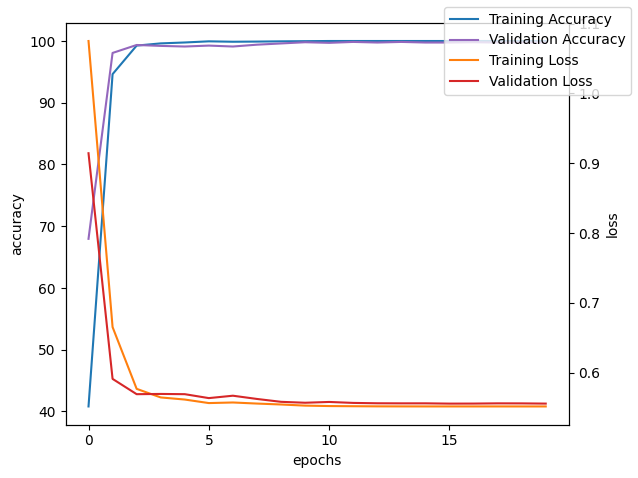

Accuracy of the model on the validation set: 99.75%
Accuracy of the model on the test set: 99.4%


  5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

 EPOCH: 01/20 TRAIN-ACC: 33.20 TRAIN-LOSS: 1.2186 | VAL-ACC: 33.53 VAL-LOSS: 1.2161


 10%|█         | 2/20 [00:03<00:30,  1.67s/it]

 EPOCH: 02/20 TRAIN-ACC: 33.26 TRAIN-LOSS: 1.2179 | VAL-ACC: 33.33 VAL-LOSS: 1.2181


 15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

 EPOCH: 03/20 TRAIN-ACC: 33.20 TRAIN-LOSS: 1.2178 | VAL-ACC: 33.28 VAL-LOSS: 1.2186


 20%|██        | 4/20 [00:06<00:25,  1.58s/it]

 EPOCH: 04/20 TRAIN-ACC: 33.42 TRAIN-LOSS: 1.2167 | VAL-ACC: 33.58 VAL-LOSS: 1.2156


 25%|██▌       | 5/20 [00:07<00:23,  1.57s/it]

 EPOCH: 05/20 TRAIN-ACC: 33.32 TRAIN-LOSS: 1.2179 | VAL-ACC: 33.43 VAL-LOSS: 1.2171


 30%|███       | 6/20 [00:09<00:21,  1.56s/it]

 EPOCH: 06/20 TRAIN-ACC: 33.35 TRAIN-LOSS: 1.2172 | VAL-ACC: 33.43 VAL-LOSS: 1.2171


 35%|███▌      | 7/20 [00:11<00:20,  1.55s/it]

 EPOCH: 07/20 TRAIN-ACC: 33.18 TRAIN-LOSS: 1.2179 | VAL-ACC: 33.38 VAL-LOSS: 1.2176


 40%|████      | 8/20 [00:12<00:18,  1.55s/it]

 EPOCH: 08/20 TRAIN-ACC: 33.18 TRAIN-LOSS: 1.2185 | VAL-ACC: 33.38 VAL-LOSS: 1.2176


 45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

 EPOCH: 09/20 TRAIN-ACC: 33.18 TRAIN-LOSS: 1.2185 | VAL-ACC: 33.43 VAL-LOSS: 1.2171


 50%|█████     | 10/20 [00:15<00:15,  1.60s/it]

 EPOCH: 10/20 TRAIN-ACC: 33.20 TRAIN-LOSS: 1.2185 | VAL-ACC: 33.33 VAL-LOSS: 1.2181


 55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it]

 EPOCH: 11/20 TRAIN-ACC: 33.19 TRAIN-LOSS: 1.2189 | VAL-ACC: 33.38 VAL-LOSS: 1.2176


 60%|██████    | 12/20 [00:19<00:12,  1.59s/it]

 EPOCH: 12/20 TRAIN-ACC: 33.20 TRAIN-LOSS: 1.2186 | VAL-ACC: 33.38 VAL-LOSS: 1.2176


 65%|██████▌   | 13/20 [00:20<00:11,  1.58s/it]

 EPOCH: 13/20 TRAIN-ACC: 33.27 TRAIN-LOSS: 1.2181 | VAL-ACC: 33.28 VAL-LOSS: 1.2186


 70%|███████   | 14/20 [00:22<00:09,  1.57s/it]

 EPOCH: 14/20 TRAIN-ACC: 33.26 TRAIN-LOSS: 1.2183 | VAL-ACC: 33.53 VAL-LOSS: 1.2161


 75%|███████▌  | 15/20 [00:23<00:07,  1.56s/it]

 EPOCH: 15/20 TRAIN-ACC: 33.25 TRAIN-LOSS: 1.2178 | VAL-ACC: 33.38 VAL-LOSS: 1.2176


 80%|████████  | 16/20 [00:25<00:06,  1.56s/it]

 EPOCH: 16/20 TRAIN-ACC: 33.24 TRAIN-LOSS: 1.2187 | VAL-ACC: 33.33 VAL-LOSS: 1.2181


 85%|████████▌ | 17/20 [00:26<00:04,  1.56s/it]

 EPOCH: 17/20 TRAIN-ACC: 33.09 TRAIN-LOSS: 1.2188 | VAL-ACC: 33.33 VAL-LOSS: 1.2181


 90%|█████████ | 18/20 [00:28<00:03,  1.59s/it]

 EPOCH: 18/20 TRAIN-ACC: 33.15 TRAIN-LOSS: 1.2187 | VAL-ACC: 33.43 VAL-LOSS: 1.2171


 95%|█████████▌| 19/20 [00:30<00:01,  1.62s/it]

 EPOCH: 19/20 TRAIN-ACC: 33.24 TRAIN-LOSS: 1.2184 | VAL-ACC: 33.43 VAL-LOSS: 1.2171


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

 EPOCH: 20/20 TRAIN-ACC: 33.24 TRAIN-LOSS: 1.2183 | VAL-ACC: 33.33 VAL-LOSS: 1.2181


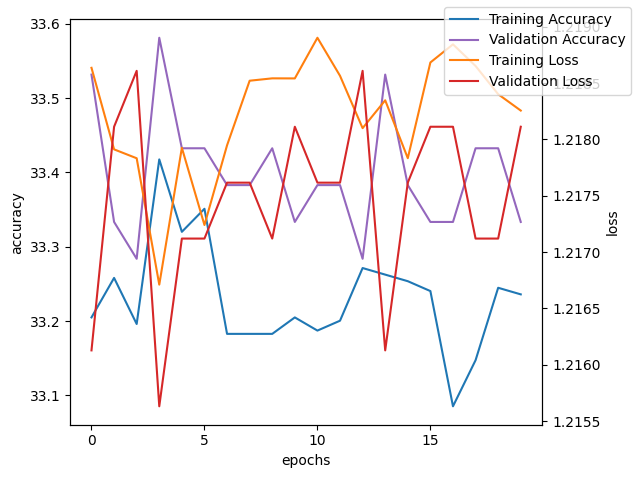

Accuracy of the model on the validation set: 33.4%
Accuracy of the model on the test set: 35.0%


  5%|▌         | 1/20 [00:00<00:10,  1.76it/s]

 EPOCH: 01/20 TRAIN-ACC: 34.45 TRAIN-LOSS: 1.1002 | VAL-ACC: 34.47 VAL-LOSS: 1.0986


 10%|█         | 2/20 [00:01<00:10,  1.76it/s]

 EPOCH: 02/20 TRAIN-ACC: 34.94 TRAIN-LOSS: 1.0986 | VAL-ACC: 34.42 VAL-LOSS: 1.0986


 15%|█▌        | 3/20 [00:01<00:09,  1.75it/s]

 EPOCH: 03/20 TRAIN-ACC: 34.96 TRAIN-LOSS: 1.0986 | VAL-ACC: 34.57 VAL-LOSS: 1.0986


 20%|██        | 4/20 [00:02<00:09,  1.74it/s]

 EPOCH: 04/20 TRAIN-ACC: 34.92 TRAIN-LOSS: 1.0986 | VAL-ACC: 34.77 VAL-LOSS: 1.0986


 25%|██▌       | 5/20 [00:02<00:08,  1.72it/s]

 EPOCH: 05/20 TRAIN-ACC: 34.62 TRAIN-LOSS: 1.0986 | VAL-ACC: 35.47 VAL-LOSS: 1.0986


 30%|███       | 6/20 [00:03<00:08,  1.72it/s]

 EPOCH: 06/20 TRAIN-ACC: 33.81 TRAIN-LOSS: 1.0986 | VAL-ACC: 34.97 VAL-LOSS: 1.0986


 35%|███▌      | 7/20 [00:04<00:07,  1.72it/s]

 EPOCH: 07/20 TRAIN-ACC: 33.02 TRAIN-LOSS: 1.0986 | VAL-ACC: 32.14 VAL-LOSS: 1.0986


 40%|████      | 8/20 [00:04<00:06,  1.73it/s]

 EPOCH: 08/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.89 VAL-LOSS: 1.0986


 45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

 EPOCH: 09/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.80 VAL-LOSS: 1.0986


 50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

 EPOCH: 10/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.99 VAL-LOSS: 1.0986


 55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

 EPOCH: 11/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.89 VAL-LOSS: 1.0986


 60%|██████    | 12/20 [00:06<00:04,  1.75it/s]

 EPOCH: 12/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.89 VAL-LOSS: 1.0986


 65%|██████▌   | 13/20 [00:07<00:03,  1.77it/s]

 EPOCH: 13/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.85 VAL-LOSS: 1.0986


 70%|███████   | 14/20 [00:08<00:03,  1.71it/s]

 EPOCH: 14/20 TRAIN-ACC: 33.67 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.94 VAL-LOSS: 1.0986


 75%|███████▌  | 15/20 [00:08<00:03,  1.59it/s]

 EPOCH: 15/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.85 VAL-LOSS: 1.0986


 80%|████████  | 16/20 [00:09<00:02,  1.53it/s]

 EPOCH: 16/20 TRAIN-ACC: 33.76 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.75 VAL-LOSS: 1.0986


 85%|████████▌ | 17/20 [00:10<00:02,  1.48it/s]

 EPOCH: 17/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.89 VAL-LOSS: 1.0986


 90%|█████████ | 18/20 [00:10<00:01,  1.46it/s]

 EPOCH: 18/20 TRAIN-ACC: 33.74 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.80 VAL-LOSS: 1.0986


 95%|█████████▌| 19/20 [00:11<00:00,  1.49it/s]

 EPOCH: 19/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.99 VAL-LOSS: 1.0986


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

 EPOCH: 20/20 TRAIN-ACC: 33.76 TRAIN-LOSS: 1.0986 | VAL-ACC: 31.94 VAL-LOSS: 1.0986


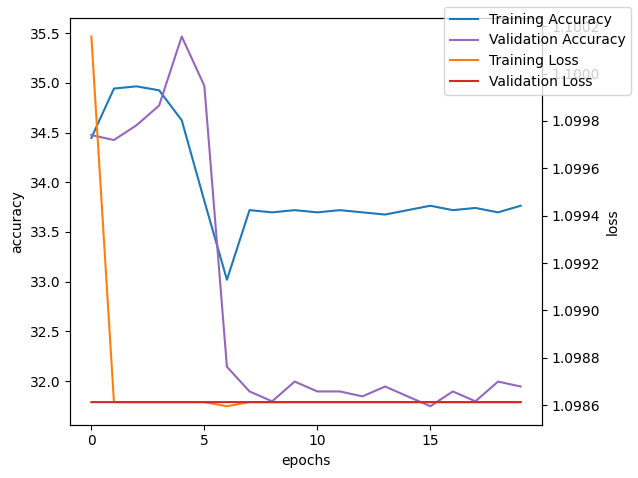

Accuracy of the model on the validation set: 31.85%
Accuracy of the model on the test set: 32.6%


In [ ]:
# Make class for performing training procedure given predictor model
class AblationTester():
  def __init__(self):
    pass

  def run_test(self, predictor):
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else:
        device = torch.device('cpu')

    model = predictor.to(device)

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    trainer = Trainer(model=model,
                      device=device,
                      criterion=criterion,
                      optimizer=optimizer,
                      training_DataLoader=dataloader_training,
                      validation_DataLoader=dataloader_validation,
                      epochs=20)

    trainer.run_trainer()
    return model
ablation_tester = AblationTester()

"""
Test 1: Remove the symmetry-related components by commenting out the slice layer, the symmetryconv layer, and the symmetry pool layer
"""
class OriginPredictor_test1(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test1, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            # sc.Slice(4, False),

            # sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            # nn.Dropout2d(0.3),
            # nn.ReLU(),

            # sc.SymmetryPool(),

            nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(96, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model_test1 = ablation_tester.run_test(OriginPredictor_test1())

model_test1.eval()
with torch.no_grad():
    out = model_test1(X_val.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test1(X_test.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

"""
Test 2: Remove later convolutional layers that recognize super cells and global patterns
"""
class OriginPredictor_test2(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test2, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            sc.SymmetryPool(),

            # nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),

            # nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(8800, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model_test2 = ablation_tester.run_test(OriginPredictor_test2())

model_test2.eval()
with torch.no_grad():
    out = model_test2(X_val.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test2(X_test.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

"""
Test 3: Remove everything but input layer and last linear layer
"""
class OriginPredictor_test3(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test3, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            # sc.Slice(4, False),

            # sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            # nn.Dropout2d(0.3),
            # nn.ReLU(),

            # sc.SymmetryPool(),

            # nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),

            # nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(14400, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model_test3 = ablation_tester.run_test(OriginPredictor_test3())

model_test3.eval()
with torch.no_grad():
    out = model_test3(X_val.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test3(X_test.to(device))  # send through model/network

out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
max_index_pred = torch.argmax(out_softmax, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [ ]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###